In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchsummary import summary
from torchvision import datasets, models, transforms

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fine-Tuning
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

# Feature Extraction - freeze the weight
for param in model.parameters():
    pass # param.requires_grad = False

# ResNet34 default output layer nodes = 1000
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

a = summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─ReLU: 3-13                   -

In [4]:
input_path = "./data/cats-and-dogs/" 

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(input_path + 'training_set/training_set', data_transforms['train']),
    'validation': datasets.ImageFolder(input_path + 'test_set/test_set', data_transforms['validation'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=32, shuffle=False)
}

In [5]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train','validation']:
            y_pred = []
            y_true = []
            
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                model = model.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                
                if phase == 'validation':
                    y_pred.extend(preds.data.cpu().numpy())
                    y_true.extend(labels.data.cpu().numpy())

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return y_true,y_pred,model

In [6]:
y_true,y_pred,model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.1100, acc: 0.9548
validation loss: 0.0361, acc: 0.9881
Epoch 2/3
----------
train loss: 0.0409, acc: 0.9864
validation loss: 0.0283, acc: 0.9906
Epoch 3/3
----------
train loss: 0.0308, acc: 0.9894
validation loss: 0.0388, acc: 0.9876


In [ ]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j]}' for j in range(32)))

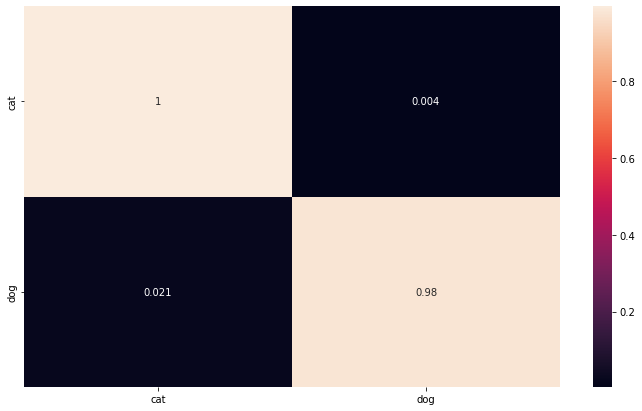

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

classes = ('cat','dog')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * len(classes), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('cf-cat-and-dog-resnet34.png')

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1011
           1       1.00      0.98      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023

